In [41]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [42]:
# data parameters
n_monto_carlo = 10 ** 5
n_assets = 7
risky_asset = ['TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META']

In [43]:
# download the data
prices_df = pd.read_csv("yishuhan.csv")
prices_df = prices_df.drop(columns=['Unnamed: 0'])
prices_df['Date'] = pd.date_range(start='2022-09-21', end='2023-01-18', freq='D')
prices_df.set_index('Date', inplace=True)
print(f'read {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df.head(3)

read 120 rows of data.


,TSLA,AAPL,GOOG,MSFT,NVDA,AMZN,META
Date,,,,,,,
2022-09-21,-0.002107,0.000972,-0.000520,0.001189,-0.000575,0.002466,0.007481
2022-09-22,0.005101,-0.000250,-0.001048,-0.000423,0.002137,0.002199,0.004390
2022-09-23,0.006431,0.000416,0.001767,0.002077,0.006458,0.000834,0.003045


In [44]:
# show the percentage returns
returns_df = prices_df
returns_df.head()

,TSLA,AAPL,GOOG,MSFT,NVDA,AMZN,META
Date,,,,,,,
2022-09-21,-0.002107,0.000972,-0.000520,0.001189,-0.000575,0.002466,0.007481
2022-09-22,0.005101,-0.000250,-0.001048,-0.000423,0.002137,0.002199,0.004390
2022-09-23,0.006431,0.000416,0.001767,0.002077,0.006458,0.000834,0.003045
2022-09-24,0.002294,0.000645,0.000253,0.002052,0.002021,0.000068,0.000028
2022-09-25,0.000125,-0.000218,0.000995,-0.000845,0.005022,0.000794,0.001769


In [45]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(TSLA    0.205462
 AAPL    0.036837
 GOOG    0.102142
 MSFT    0.144430
 NVDA    0.335053
 AMZN    0.065944
 META    0.219844
 dtype: float64,
           TSLA          AAPL          GOOG      MSFT      NVDA          AMZN  \
 TSLA  0.000755 -4.366601e-06  3.188777e-05 -0.000010  0.000143  1.185058e-05   
 AAPL -0.000004  2.012567e-06 -2.860186e-07  0.000002 -0.000001 -6.059581e-07   
 GOOG  0.000032 -2.860186e-07  1.781526e-04 -0.000067 -0.000042 -5.292661e-05   
 MSFT -0.000010  2.239529e-06 -6.724966e-05  0.000241  0.000116 -6.487306e-05   
 NVDA  0.000143 -1.219345e-06 -4.170516e-05  0.000116  0.000289 -4.844375e-05   
 AMZN  0.000012 -6.059581e-07 -5.292661e-05 -0.000065 -0.000048  1.274309e-04   
 META -0.000133  3.064791e-06 -1.586333e-04 -0.000056  0.000034  8.104626e-05   
 
           META  
 TSLA -0.000133  
 AAPL  0.000003  
 GOOG -0.000159  
 MSFT -0.000056  
 NVDA  0.000034  
 AMZN  0.000081  
 META  0.000822  )

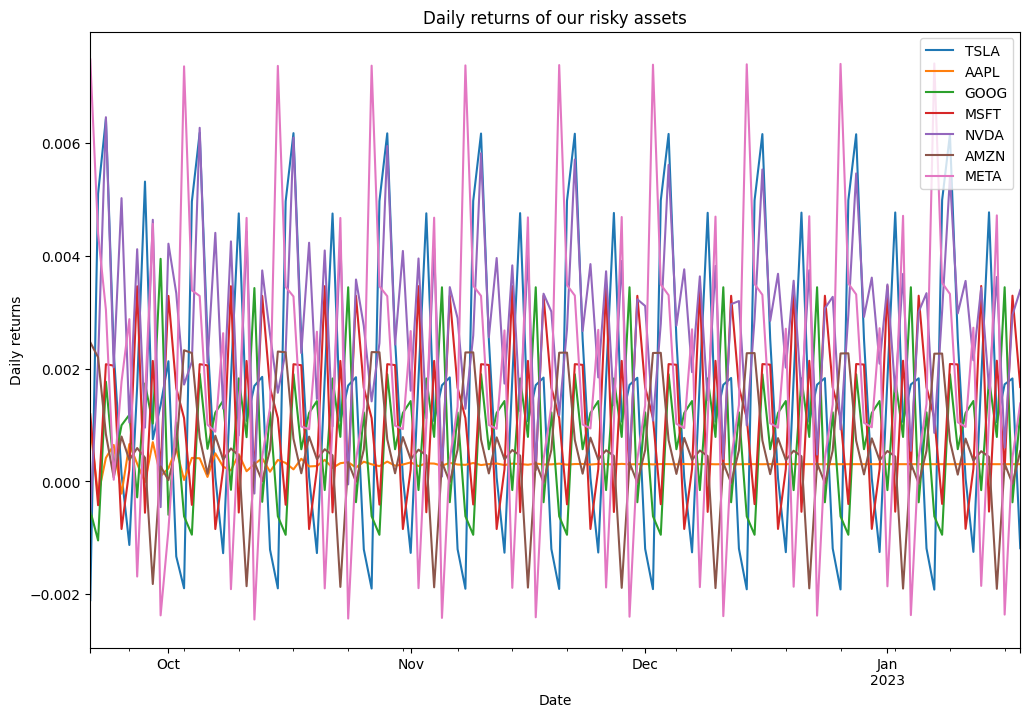

In [46]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [47]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [48]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [49]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [50]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

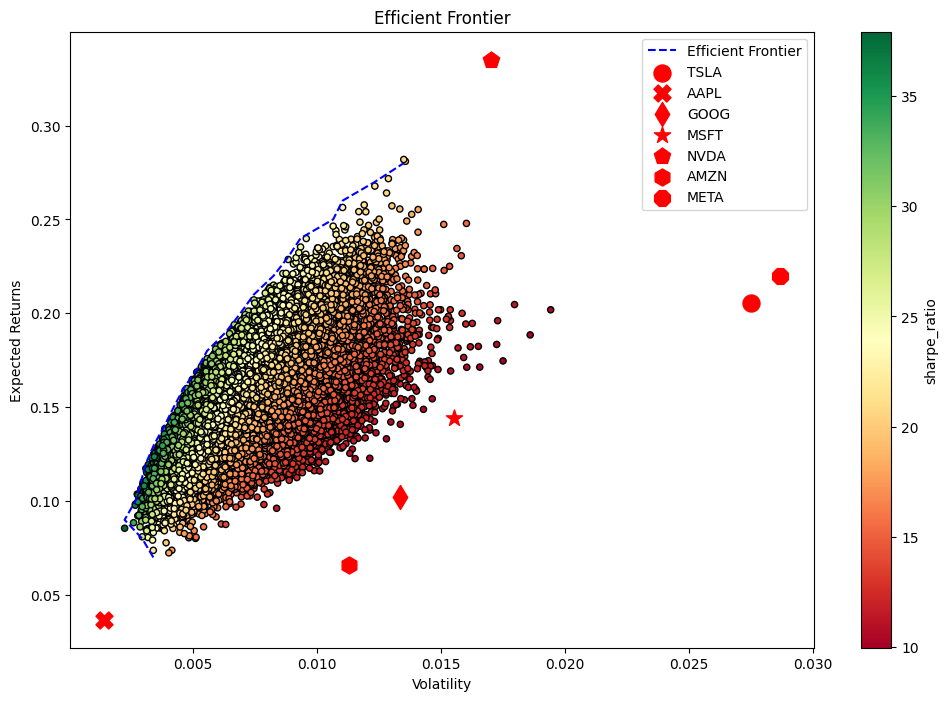

In [51]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

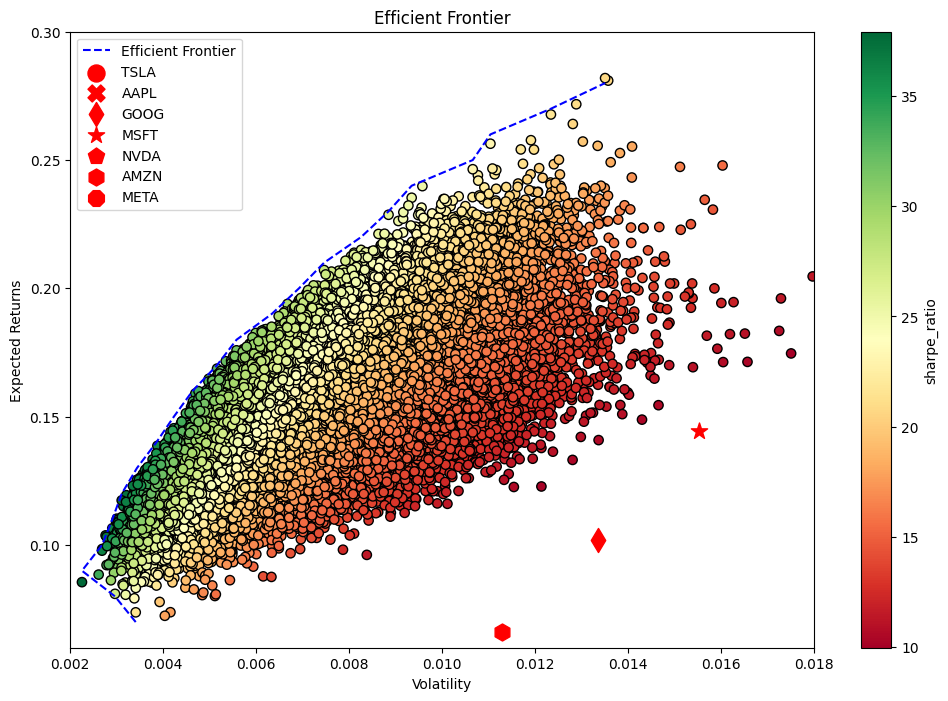

In [59]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax, s = 45)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier',\
       xlim = (0.002, 0.018), ylim = (0.06, 0.3))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [53]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [54]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 8.55% volatility: 0.23% sharpe_ratio: 3791.13% 
Weights:
TSLA: 0.87% AAPL: 42.84% GOOG: 17.38% MSFT: 10.30% NVDA: 4.51% AMZN: 21.28% META: 2.82% 

In [55]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 8.55% volatility: 0.23% sharpe_ratio: 3791.13% 
Weights:
TSLA: 0.87% AAPL: 42.84% GOOG: 17.38% MSFT: 10.30% NVDA: 4.51% AMZN: 21.28% META: 2.82% 

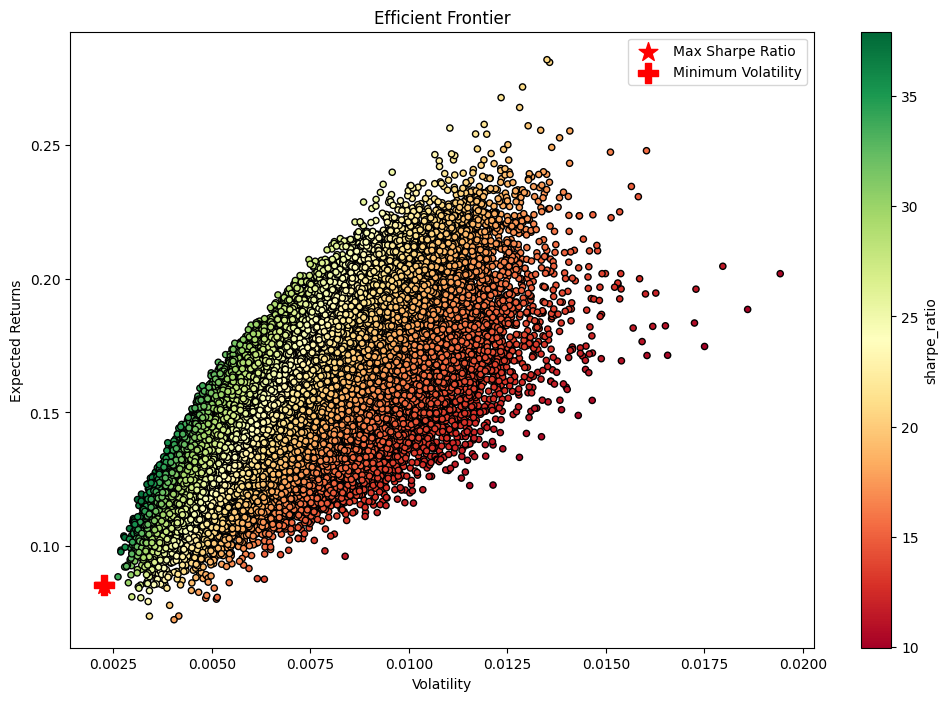

In [56]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()